In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import csv
from tqdm.auto import tqdm

In [2]:
def hex2rgb(hx):
    return tuple(int(hx[i:i+2], 16) for i in (0, 2, 4))

In [180]:
basepath = Path('data/beta')
sources = sorted(list(basepath.glob('2018-10-02_04*.avi')))
print(sources)

align_labels = [cv2.cvtColor(cv2.imread(str(source.with_suffix('.align.png'))), cv2.COLOR_BGR2RGB) for source in sources]
align_targets = [cv2.cvtColor(cv2.imread(str(source.with_suffix('.target.png'))), cv2.COLOR_BGR2RGB) for source in sources]
fig, ax = plt.subplots(2, 2, figsize=(17, 12))
for n in range(len(align_labels)):
    ax[n, 0].imshow(align_labels[n])
    ax[n, 0].axis('off')
    ax[n, 1].imshow(align_targets[n])
    ax[n, 1].axis('off')
plt.tight_layout()

[WindowsPath('data/beta/2018-10-02_04-40-59_cam_0.avi'), WindowsPath('data/beta/2018-10-02_04-40-59_cam_1.avi')]


error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [176]:
def read_csv(source):
    source = Path(source).resolve()
    dst_pts = []
    src_pts = []
    colors = []
    with open(source.with_suffix('.align.csv'), 'r') as csv_file:
        for n, row in enumerate(csv.reader(csv_file)):
            if not n:
                continue
            row_ints = list(map(int, row[:-1]))
            dst_pts.append((row_ints[0], row_ints[1]))
            src_pts.append((row_ints[2], row_ints[3]))
            colors.append(hex2rgb(row[4].strip()[2:]))
    return src_pts, dst_pts, colors

In [177]:
def calculate_h(src_pts, dst_pts):
    h, status = cv2.findHomography(np.array(src_pts), np.array(dst_pts))  # takes several algorithms
    return h

In [178]:
def calculate_m(src_pts, dst_pts):
    """Needs 4 points on edges, methinks"""
    m = cv2.getPerspectiveTransform(np.array(src_pts), np.array(dst_pts))
    return m

In [179]:
def correct_image(img, corr_mat, width, height):
    return cv2.warpPerspective(img, corr_mat, (height, width))

In [79]:
def find_outline(img):
    return cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [131]:
def fix_mask(mask):
    """Get outline of a mask, fix smaller holes """
    contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = np.array([cv2.contourArea(cnt) for cnt in contours])
    mask_outline = np.zeros((mask.shape[0], mask.shape[1], 3), dtype='uint8')
    cv2.drawContours(mask_outline, contours, np.argmax(areas), (1, 0, 0), maxLevel=0, thickness=-1)
    
    morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    mask_outline = cv2.morphologyEx(mask_outline, cv2.MORPH_CLOSE, morph_kernel, iterations=2)
    return np.sum(mask_outline, axis=2)

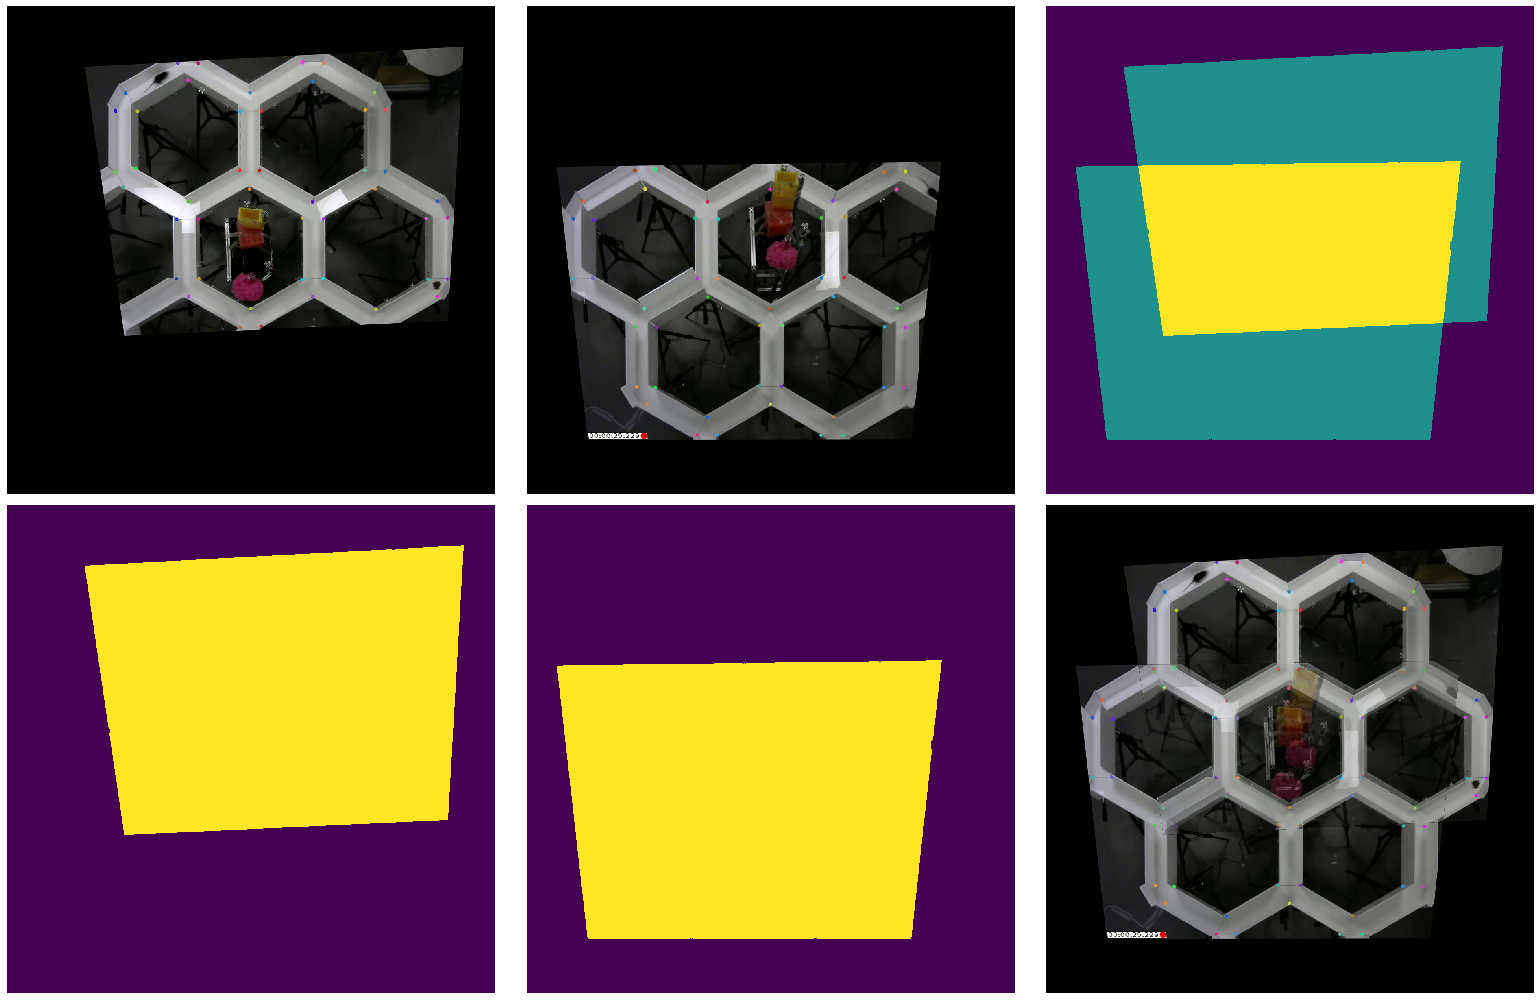

In [173]:
height, width, channels = align_targets[0].shape

fig, ax = plt.subplots(2, 3, figsize=(22, 14))

corrected_images = []
masks = []

for n, source in enumerate(sources):
    # Read in alignment labels
    sp, dp, colors = read_csv(source)
    
    # Calculate Homography Matrix
    h = calculate_h(sp, dp)
    
    # Apply perspective correction with Homography matrix
    corr_img = cv2.warpPerspective(align_labels[n], h, (height, width), flags=cv2.INTER_CUBIC, borderValue=(0, 0, 0))
    corrected_images.append(corr_img)
    ax[0, n].imshow(corr_img)
    
    # Estimate background/corrected image
    mask = np.sum((corr_img > 0).astype('uint8'), axis=2)
#     ax[1, n].imshow(mask)
    
    # Correct the mask to remove holes
    fixed_mask = fix_mask(mask)
    masks.append(fixed_mask)
    ax[1, n].imshow(fixed_mask)
    
mask = masks[0] + masks[1]
ax[0, 2].imshow(mask)

merged = add_merge(corrected_images[0] * masks[0][:,:,None], corrected_images[1] * masks[1][:,:,None], mask, blur=False)
ax[1, 2].imshow(merged);

for a in range(len(ax.flatten())):
    ax.flatten()[a].axis('off')
plt.tight_layout()

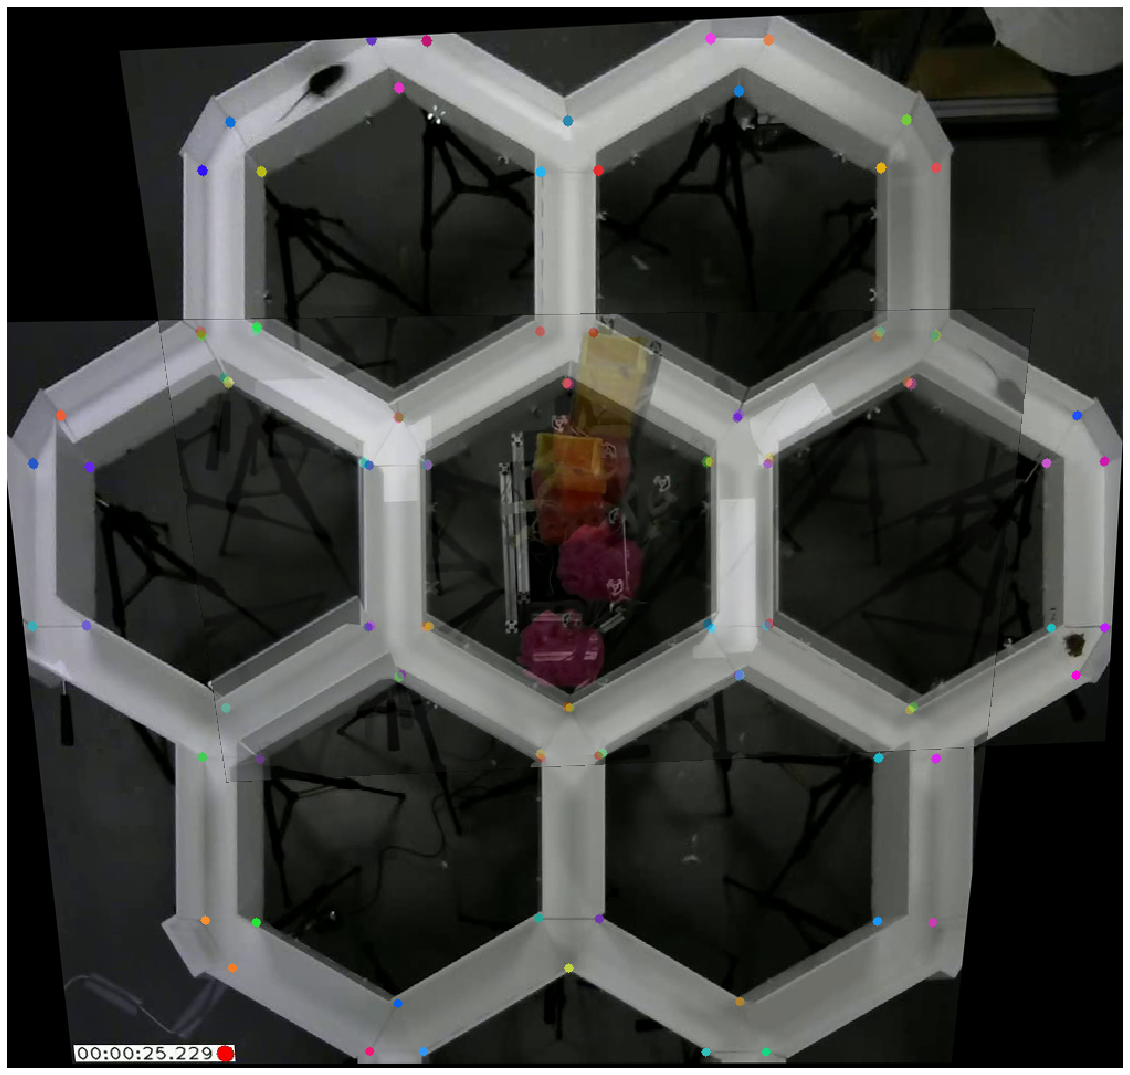

In [174]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(merged[110:1070, 90:1100, :].astype('uint8'))
plt.axis('off');

In [158]:
def add_merge(img1, img2, mask, blur=False):
    if blur:
        print(mask.shape, mask.dtype)
        mask = cv2.GaussianBlur(mask.astype('float'), (3,3), 0)

    alpha = (mask > 1).astype('float') * .5
    alpha[alpha==0] = 1.
    alpha = alpha[:, :, None]
    merged = img1.astype('float')  * alpha + img2.astype('float')  * alpha
    return merged.astype('uint8')

In [235]:
captures = [cv2.VideoCapture(str(src)) for src in sources]
Hs = []
for n, source in enumerate(sources):
    dp, sp, colors = read_csv(source)
    Hs.append(calculate_h(dp, sp))

for t in tqdm(range(1000)):
    images = [cap.read()[1] for cap in captures]
    try:
        corr_images = [cv2.warpPerspective(img, Hs[n], (height, width), flags=cv2.INTER_CUBIC) for n, img in enumerate(images)]
    except BaseException:
        break
    merged = corr_images[0]  * alpha[:, :, None] + corr_images[1]  * alpha[:, :, None]
    cv2.imwrite(f'tmp/img{t:03d}.png', merged[110:1070, 90:1100, :])

In [169]:
alpha = (mask > 1).astype('float') * .5
alpha[alpha==0] = 1.
alpha.max()

1.0

In [ ]:
def min_merge(img1, img2, mask):
    